# Gradiente e Classificação multinomial

Nícolas Hecker Silva RA 186132


## Descrição 

Esta tarefa explora conceitos de c ́alculo vetorial, otimiza ̧c ̃ao e m ́etodos de gradiente descendente no contexto de aprendizado de m ́aquina, com foco em classifica ̧c ̃ao multinomial.

## Etapa 1: Funções Convexas e Otimização

Dado uma função $f(x) = x^TAx + b^Tx + c$ faça três versões mudando a matriz A para que a função seja:


- Fortemente Convexa.
- Convexa.
- Não Convexa.

Evidencia cada uma das propriedades.


Dado o enunciado acima, como não foram especificados os tipos das variáveis e constantes será assumido que:
x: É um vetor coluna de dimensão n (nx1)
A: É uma matriz quadrada de dimensão nxn
b: É um vetor coluna de dimensão n (nx1)
c: É um escalar

Dessa forma a dimensão das parcelas será:

$x^TAx = (nx1)^T * (nxn) * (nx1) = (1xn) * (nxn) * (nx1) = (1)$

$b^Tx = (nx1)^T * (nx1) = (1xn) * (nx1) = (1)$

$c = (1)$

Dessa forma f(x) retornará um valor real.

Uma função $ f: \mathbb{R}^n \to \mathbb{R} $ é **fortemente convexa** com parâmetro $ m > 0 $ se, para todo $ x, y \in \mathbb{R}^n $, satisfizer:

$
f(x) \geq f(y) + \nabla f(y)^T (x - y) + \frac{m}{2} \| x - y \|^2.
$

Se $ f(x) = x^T A x + b^T x + c $, para que $ f $ seja fortemente convexa, a matriz $ A $ deve ser **positiva definida** com todos os autovalores maiores ou iguais a $ m $, ou seja, $ \lambda_{\min}(A) \geq m > 0 $.

Por fim, basta que o menor autovalor de $A$ seja maior que 0, sendo (novamente) **positiva definida**. E para isso, basta ela ser simétrica. Uma matriz exemplo seria

$$
A = \begin{pmatrix}
  2 & 0 \\
  0 & 3 
\end{pmatrix}
$$

cujos autovalores são exatamente 2 e 3.

Já para a função ser **convexa** basta que seus autovalores sejam não negativos, ou seja, eles podem ser nulos. Dessa forma, a matriz exemplo

$$
A = \begin{pmatrix}
  2 & 0 \\
  0 & 0
\end{pmatrix}
$$

terá os autovalores 0 e 2, fazendo com que f(x) seja **convexa**.

Dessa forma, para que a função f seja **não convexa**, é necessário que algum autovalor seja negativo, pois nesse caso a função f(x) não terá curvatura positiva em todas as direções, podendo curvar-se para baixo em algumas direções, o que viola a convexidade.

Um exemplo é a matriz

$$
A = \begin{pmatrix}
  2 & 0 \\
  0 & -1
\end{pmatrix}
$$

em que os autovalores são 2 e -1, sendo -1 um valor negativo fazendo com que A não seja semidefinida positiva e, portanto, não convexa.



# 2 Classificação Multinomial com MNIST

O primeiro passo é baixar todas as dependências necessárias

In [1]:
!python -m pip install tqdm
!python -m pip install torch
!python -m pip install matplotlib
!python -m pip install numpy

import os
import numpy as np
import struct
from array import array
from os.path  import join
from tqdm import tqdm
from time import time
%matplotlib inline
import matplotlib.pyplot as plt
import random

# seta a seed para reprodução dos resultados
seed = 42
random.seed(seed)
np.random.seed(seed)


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


## Dataset

Uma parte muito importante é baixar o dataset mnist. Ele será baixado usando o comando shell curl e será colocado na pasta dataset-t3

In [2]:
# cria pasta dataset-t3
os.makedirs('dataset-t3', exist_ok=True)

if not os.path.exists('dataset-t3/d.zip'):
    !curl -L -o dataset-t3/d.zip\
    https://www.kaggle.com/api/v1/datasets/download/hojjatk/mnist-dataset
    !unzip dataset-t3/d.zip -d dataset-t3

Para verificar as imagens (uma vez q a extensão delas não é visível), vamos usar o código fornecido pelos autores do MNIST no kaggle (duas células abaixo)

In [3]:
#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)   

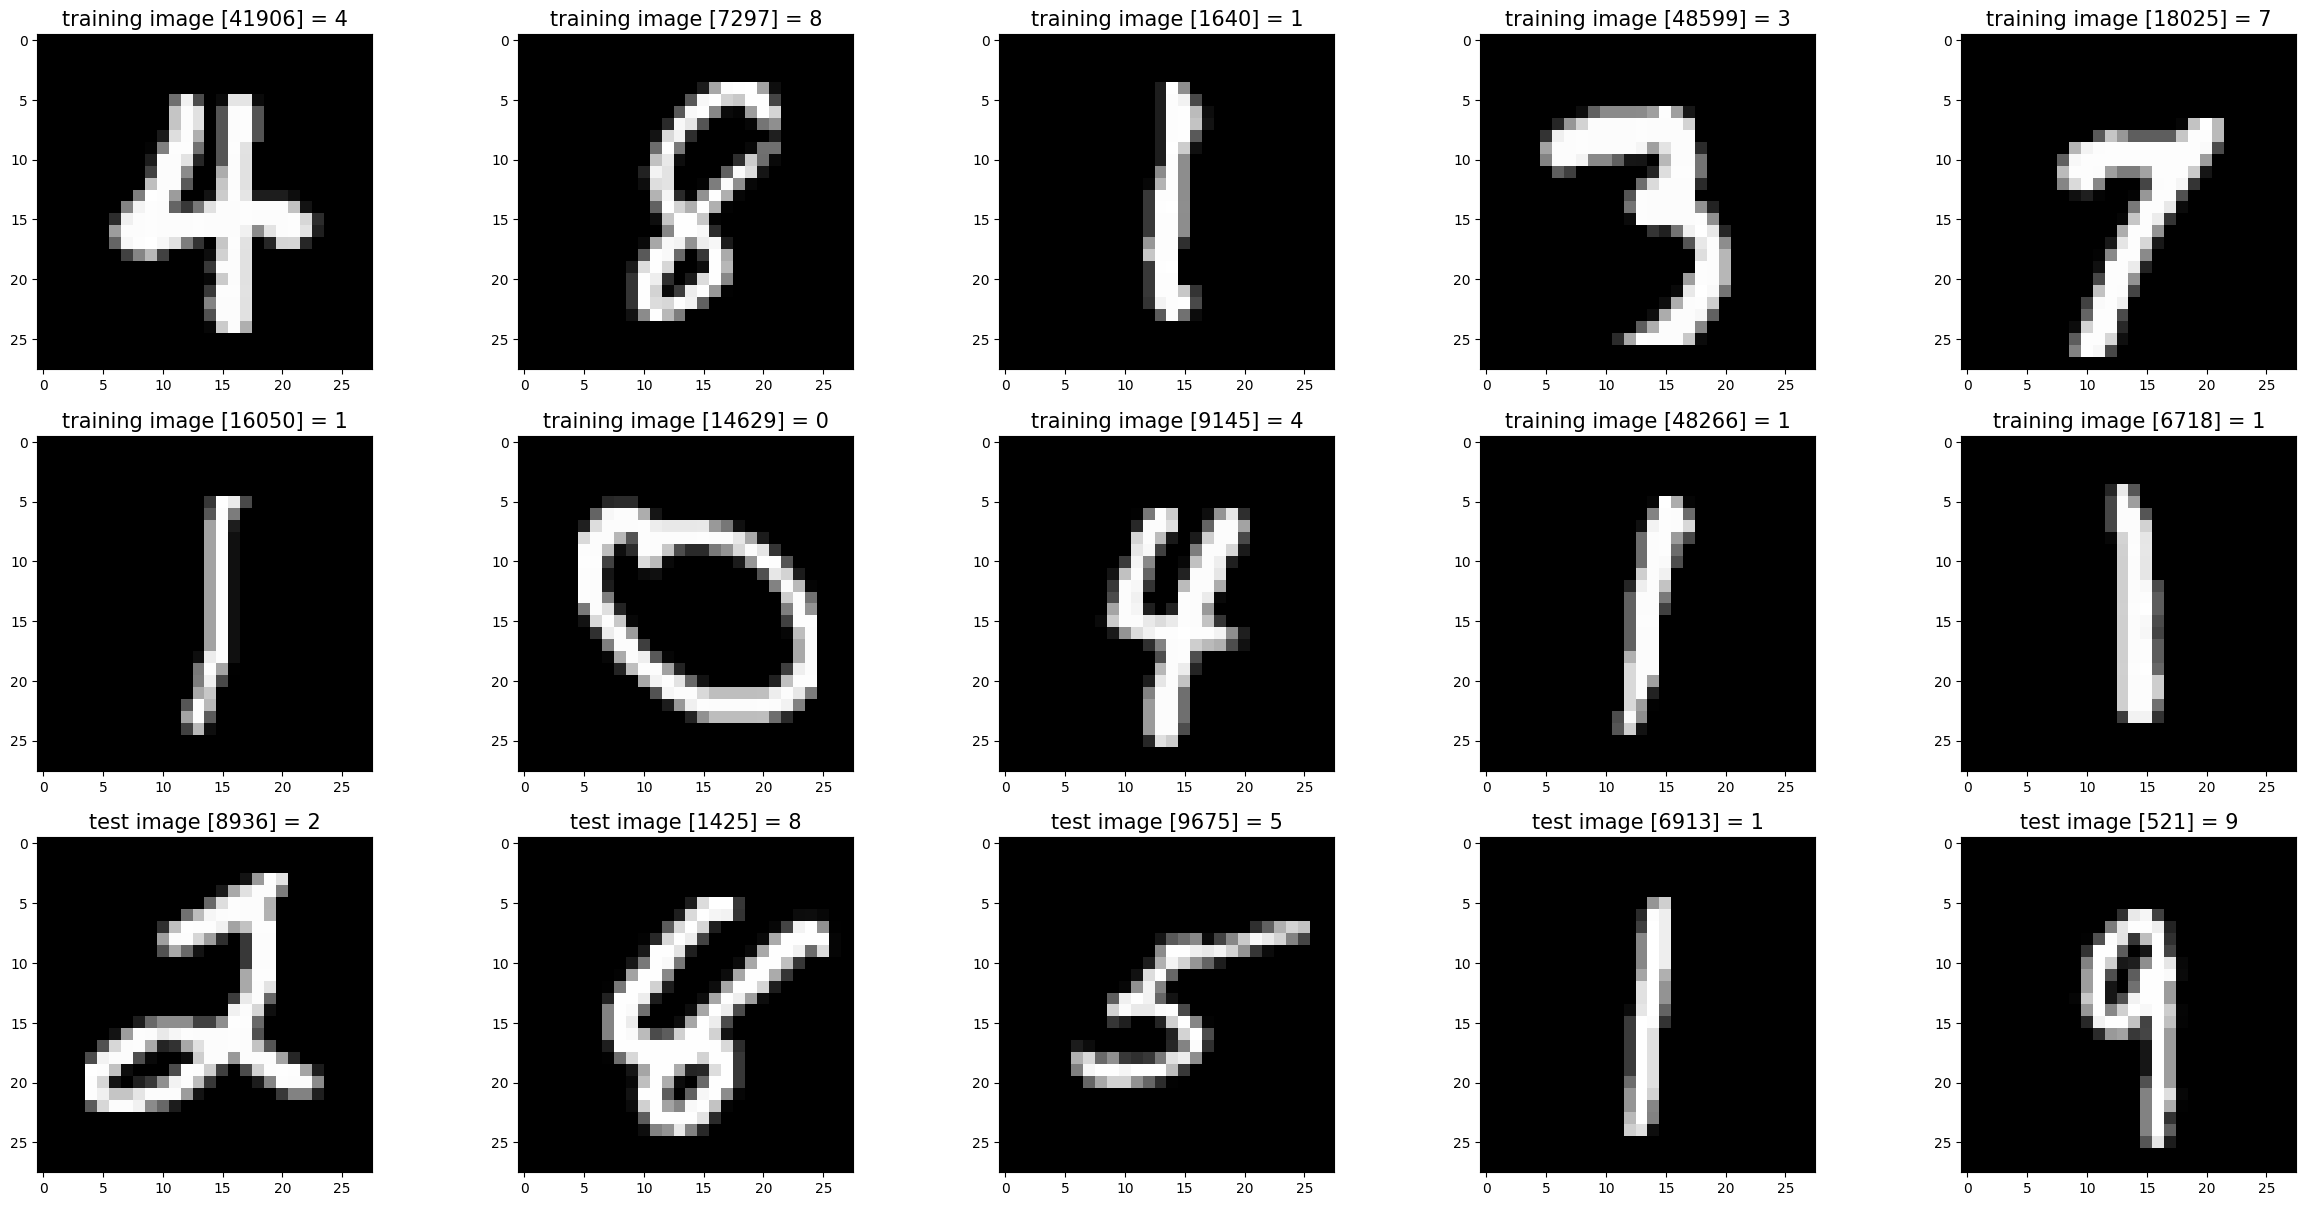

In [4]:
#
# Verify Reading Dataset via MnistDataloader class
#
#
# Set file paths based on added MNIST Datasets
#
input_path = 'dataset-t3'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

Agora vamos colocar os nossos conjuntos de teste e treino em vetores numpy

In [5]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)



print('x_train.shape =', x_train.shape)
print('y_train.shape =', np.array(y_train).shape)

x_train.shape = (60000, 28, 28)
y_train.shape = (60000,)


Agora podemos treinar um modelo simples de classificação logística para essa tarefa.

Aqui definimos uma métrica de acurácia em que simplesmente contamos quantas amostras foram preditas corretamente.

É definido uma função de softmax para traduzir o vetor de probabilidades em um vetor binário de chutes com apenas o mais provável.

Depois é definido o loop de treino, que utiliza como parâmetros o número de classes, os conjuntos de treino e teste, a taxa de aprendizado e o número de iterações de treino. Também é medido o tempo que cada etapa consome. O método utilizado é o GD (gradiente descendente) em que o conjunto de dados completo é utilizado para atualizar os pesos em cada iteração. Isso leva a uma visão global do problema, mas um custo muito grande em memória e processamento.

Depois é utilizado a função predict para verificar o desempenho do modelo no conjunto de teste.

100%|██████████| 200/200 [00:45<00:00,  4.42it/s]

Iteração 200, acurácia: 85.10%


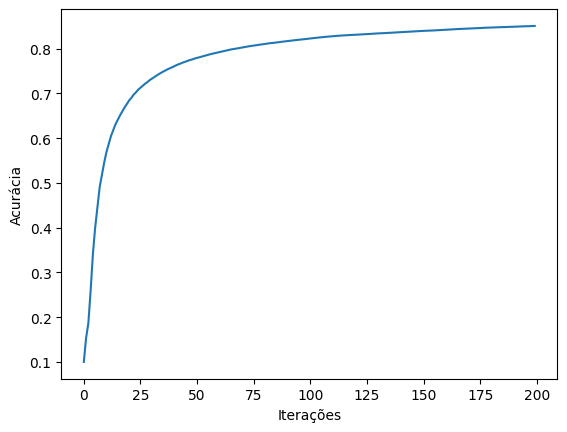

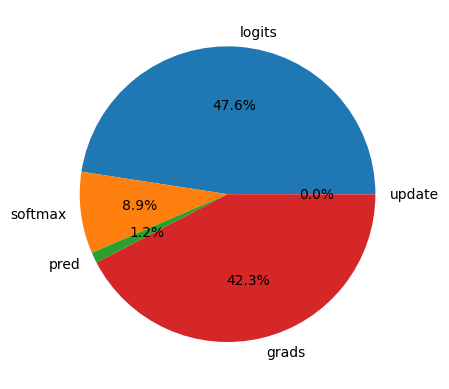

Acurácia do modelo no teste: 85.21%


In [6]:
def acuracia(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Função softmax para calcular probabilidades
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Evitar overflow numérico
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# Gradiente descendente para treinar o modelo
def train(X, y, n_classes, learning_rate=0.1, n_iter=1000):
    X = X.reshape(X.shape[0], -1)
    n_samples, n_features,  = X.shape
    W = np.random.rand(n_features, n_classes)
    b = np.zeros((1, n_classes))

    tempos = {"logits": 0, "softmax": 0, "pred": 0, "grads": 0, "update": 0}

    acuracias = np.zeros(n_iter)
    for i in tqdm(range(n_iter)):
        # Cálculo de logits e probabilidades
        medidor = time()
        logits = np.dot(X, W) + b
        tempos["logits"] += time() - medidor

        medidor = time()
        y_pred = softmax(logits)
        tempos["softmax"] += time() - medidor

        medidor = time()
        pred = np.argmax(y_pred, axis=1)
        tempos["pred"] += time() - medidor

        medidor = time()
        # Calcular e atualizar os gradientes
        y_one_hot = np.eye(n_classes)[y]
        grad_W = (1 / n_samples) * np.dot(X.T, (y_pred - y_one_hot))
        grad_b = (1 / n_samples) * np.sum(y_pred - y_one_hot, axis=0, keepdims=True)
        tempos["grads"] += time() - medidor

        medidor = time()
        W -= learning_rate * grad_W
        b -= learning_rate * grad_b
        tempos["update"] += time() - medidor


        acuracias[i] = acuracia(y, pred)
    print(f"Iteração {n_iter}, acurácia: {acuracia(y, pred) * 100:.2f}%")

    # mostra um plot com todas as acurácias
    plt.plot(acuracias)
    plt.xlabel("Iterações")
    plt.ylabel("Acurácia")
    plt.show()

    # mostra um grafico de pizza com os tempos de execução
    plt.pie(tempos.values(), labels=tempos.keys(), autopct='%1.1f%%')
    plt.show()

    return W, b

# Prever as classes
def predict(X, W, b):
    X = X.reshape(X.shape[0], -1)
    logits = np.dot(X, W) + b
    y_pred = softmax(logits)
    return np.argmax(y_pred, axis=1)


X, y = x_train, y_train
n_classes = len(np.unique(y))

# Treinamento
W, b = train(X, y, n_classes, n_iter = 200, learning_rate=0.002)

# Previsão e avaliação
y_pred = predict(x_test, W, b)
accuracy = np.mean(y_pred == y_test)
print(f"Acurácia do modelo no teste: {accuracy * 100:.2f}%")


Aqui podemos ver que o modelo foi treinado e a acurácia dele foi crescente, até atingir valores próximos a 90%, semelhante a uma curva logarítimca, em que adicionar processamento não beneficia muito mais a acurácia.

Além disso, foi registrado qual parte do treinamento consome mais tempo por iteração. Aqui podemos ver que a maior parcela é computar a saída do modelo, obtendo os logits. A segunda parte que mais ocupa processamento é o cálculo do gradiente. Essas partes são custosas pois precisam utilizar todos os pesos da rede. Entretanto, o update desses pesos é rápido. Isso possivelmente ocorre por conta das operações de update serem mais otimizadas que as operações em logits e grads.

A acurácia no conjunto de teste também foi medida, estando em 85%.

Para essa quantidade, o tempo de execução dessa célula foi de cerca de 50 segundos. Esse tempo será um padrão a ser seguidos nos outros experimentos.

Agora vamos analisar como a acurácia se comporta com o SGD, utilizando batches aleatórios.

In [7]:
from random import randint

# Função para treinamento com SGD
def train_SGD(X, y, n_classes, learning_rate=0.1, n_iter=1000, batch_size=1):
    X = X.reshape(X.shape[0], -1)
    n_samples, n_features = X.shape
    W = np.random.rand(n_features, n_classes)
    b = np.zeros((1, n_classes))

    num_batches = n_samples // batch_size

    acuracias = []

    i_registro = 1
    i_registro_passo = 1
    i_registro_passo_accel = 0.3

    for i in tqdm(range(n_iter)):
        # Em SGD, iteramos por amostras ou mini-lotes
        # sorteia um índice de batch
        idx = randint(0,num_batches)
        # Selecionar uma amostra ou mini-lote
        X_batch = X[idx*batch_size:idx*batch_size + batch_size]
        y_batch = y[idx*batch_size:idx*batch_size + batch_size]
        
        # Cálculo de logits e probabilidades
        logits = np.dot(X_batch, W) + b
        y_pred = softmax(logits)
        pred = np.argmax(y_pred, axis=1)
        
        # Calcular os gradientes para essa amostra ou mini-lote
        y_one_hot = np.eye(n_classes)[y_batch]
        grad_W = (1 / batch_size) * np.dot(X_batch.T, (y_pred - y_one_hot))
        grad_b = (1 / batch_size) * np.sum(y_pred - y_one_hot, axis=0, keepdims=True)
        
        # Atualizar os pesos e o viés com base nos gradientes
        W -= learning_rate * grad_W
        b -= learning_rate * grad_b

    # Final
    pred = np.argmax(softmax(np.dot(X, W) + b), axis=1)
    print(f"Iteração {n_iter}, acurácia: {acuracia(y, pred) * 100:.2f}%")

    return W, b

# Função para prever as classes
def predict(X, W, b):
    X = X.reshape(X.shape[0], -1)
    logits = np.dot(X, W) + b
    y_pred = softmax(logits)
    return np.argmax(y_pred, axis=1)

# Treinamento usando SGD
W, b = train_SGD(X, y, n_classes, learning_rate=0.002, n_iter=1000000, batch_size=1)

# Previsão e avaliação
y_pred = predict(x_test, W, b)
accuracy = np.mean(y_pred == y_test)
print(f"Acurácia do modelo no teste: {accuracy * 100:.2f}%")


100%|██████████| 1000000/1000000 [00:39<00:00, 25313.09it/s]


Iteração 1000000, acurácia: 89.28%
Acurácia do modelo no teste: 88.89%


Aqui, a execução levou 40 segundos. A acurácia de treino foi de 90% igualmente para a acurácia de teste, o que é melhor e mais rápido que a versão não estocástica. Adicionar a medição de acurácia no treinamento não é muito interessante, pois se for feita por step, o treinamento fica extremamente mais devagar, e se for feito em intervalos de tempo não é possível ver a subida repentina no começo. Dessa forma, a análise será restrita ao tempo e acurácia.

Nesse caso as amostras estavam sendo escolidas aleatoriamente, mas o batch-size ainda é 1. Vamos aumentar para 100 e verificar a diferença

In [8]:
from random import randint

# Função para treinamento com SGD
def train_SGD(X, y, n_classes, learning_rate=0.1, n_iter=1000, batch_size=1):
    X = X.reshape(X.shape[0], -1)
    n_samples, n_features = X.shape
    W = np.random.rand(n_features, n_classes)
    b = np.zeros((1, n_classes))

    num_batches = n_samples // batch_size
    for i in tqdm(range(n_iter)):
        # Em SGD, iteramos por amostras ou mini-lotes

        # sorteia um índice de batch
        idx = randint(0,num_batches)
        # Selecionar uma amostra ou mini-lote
        X_batch = X[idx*batch_size:idx*batch_size + batch_size]
        y_batch = y[idx*batch_size:idx*batch_size + batch_size]
        
        # Cálculo de logits e probabilidades
        logits = np.dot(X_batch, W) + b
        y_pred = softmax(logits)
        pred = np.argmax(y_pred, axis=1)
        
        # Calcular os gradientes para essa amostra ou mini-lote
        y_one_hot = np.eye(n_classes)[y_batch]
        grad_W = (1 / batch_size) * np.dot(X_batch.T, (y_pred - y_one_hot))
        grad_b = (1 / batch_size) * np.sum(y_pred - y_one_hot, axis=0, keepdims=True)
        
        # Atualizar os pesos e o viés com base nos gradientes
        W -= learning_rate * grad_W
        b -= learning_rate * grad_b
        
        # A cada 5 iterações, printa a acurácia
        if i % (n_iter//10) == 0:
            pred = np.argmax(softmax(np.dot(X, W) + b), axis=1)
            print(f"Iteração {i}, acurácia: {acuracia(y, pred) * 100:.2f}%")
    
    # Final
    pred = np.argmax(softmax(np.dot(X, W) + b), axis=1)
    print(f"Iteração {n_iter}, acurácia: {acuracia(y, pred) * 100:.2f}%")

    return W, b

# Função para prever as classes
def predict(X, W, b):
    X = X.reshape(X.shape[0], -1)
    logits = np.dot(X, W) + b
    y_pred = softmax(logits)
    return np.argmax(y_pred, axis=1)

# Treinamento usando SGD
W, b = train_SGD(X, y, n_classes, learning_rate=0.0001, n_iter=100000, batch_size=100)

# Previsão e avaliação
y_pred = predict(x_test, W, b)
accuracy = np.mean(y_pred == y_test)
print(f"Acurácia do modelo no teste: {accuracy * 100:.2f}%")


  1%|          | 563/100000 [00:00<00:50, 1964.01it/s]

Iteração 0, acurácia: 11.44%


 10%|█         | 10444/100000 [00:03<00:31, 2883.44it/s]

Iteração 10000, acurácia: 87.32%


 20%|██        | 20408/100000 [00:06<00:29, 2664.57it/s]

Iteração 20000, acurácia: 88.52%


 30%|███       | 30306/100000 [00:08<00:25, 2731.71it/s]

Iteração 30000, acurácia: 88.93%


 40%|████      | 40372/100000 [00:12<00:22, 2707.06it/s]

Iteração 40000, acurácia: 89.42%


 51%|█████     | 50533/100000 [00:15<00:19, 2532.81it/s]

Iteração 50000, acurácia: 89.65%


 60%|██████    | 60315/100000 [00:18<00:15, 2645.19it/s]

Iteração 60000, acurácia: 89.89%


 70%|███████   | 70499/100000 [00:20<00:09, 2959.92it/s]

Iteração 70000, acurácia: 90.11%


 80%|████████  | 80411/100000 [00:23<00:06, 3152.47it/s]

Iteração 80000, acurácia: 90.36%


 91%|█████████ | 90640/100000 [00:26<00:02, 3200.31it/s]

Iteração 90000, acurácia: 89.71%


100%|██████████| 100000/100000 [00:28<00:00, 3528.61it/s]


Iteração 100000, acurácia: 90.11%
Acurácia do modelo no teste: 88.56%


Com um batch size maior, o treinamento ocorre mais rapidamente, podendo até mesmo diminuir o leraning rate para atingir uma convergência melhor. Nesse caso, foi possível atingir uma acurácia de 90% em ambos conjuntos com apenas 30 segundos de treino.

Vamos comparar esse modelo ao implementado pelo pytorch.

In [9]:
# redressão logistica do pytorch
import torch

# Carregar os dados
X_train = torch.tensor(x_train.reshape(x_train.shape[0], -1), dtype=torch.float32)
y_train = torch.tensor(y_train.reshape(y_train.shape[0], -1), dtype=torch.int64)
X_test = torch.tensor(x_test.reshape(x_test.shape[0], -1), dtype=torch.float32)
y_test = torch.tensor(y_test.reshape(y_test.shape[0], -1), dtype=torch.int64)

# Definir o modelo
model = torch.nn.Linear(28*28, 10)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Treinamento
for i in range(100):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)


    y_train_one_hot = torch.nn.functional.one_hot(y_train, 10).float()

    # remove dimensão vazia do meio
    y_train_one_hot = y_train_one_hot.squeeze(1)

    loss = loss_fn(y_pred, y_train_one_hot)
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        model.eval()
        y_pred = model(X_train)

        # to numpy
        y_pred = y_pred.detach().numpy()
        y_pred = np.argmax(y_pred, axis=1)
        print(f"Iteração {i}, acurácia: {acuracia(y, y_pred) * 100:.2f}%")

    # zera a loss
    loss = 0

# Avaliação
model.eval()
y_pred = model(X_test)
acc = torch.mean((torch.argmax(y_pred, dim=1) == y_test.reshape(y_test.shape[0])).float())
print(f"Acurácia do modelo no teste: {acc * 100:.2f}%")


Iteração 0, acurácia: 22.76%
Iteração 10, acurácia: 66.85%
Iteração 20, acurácia: 81.11%
Iteração 30, acurácia: 72.68%
Iteração 40, acurácia: 88.78%
Iteração 50, acurácia: 81.49%
Iteração 60, acurácia: 81.03%
Iteração 70, acurácia: 78.82%
Iteração 80, acurácia: 90.25%
Iteração 90, acurácia: 88.67%
Acurácia do modelo no teste: 77.34%


A biblioteca pytorch é muito mais otimizada e foi possível atingir uma acurácia de 90% com apenas 5 segundos de treino. Nesse caso a taxa de aprendizado foi aumentada para 0.1, o que agiliza muito o treinamento.

Vamos testar agora alterar o otimizador para o ADAM e ver a diferença.

In [10]:
# redressão logistica do pytorch
import torch

# Carregar os dados
X_train = torch.tensor(x_train.reshape(x_train.shape[0], -1), dtype=torch.float32)
y_train = torch.tensor(y_train.reshape(y_train.shape[0], -1), dtype=torch.int64)
X_test = torch.tensor(x_test.reshape(x_test.shape[0], -1), dtype=torch.float32)
y_test = torch.tensor(y_test.reshape(y_test.shape[0], -1), dtype=torch.int64)

# Definir o modelo
model = torch.nn.Linear(28*28, 10)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Treinamento
for i in range(100):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)


    y_train_one_hot = torch.nn.functional.one_hot(y_train, 10).float()

    # remove dimensão vazia do meio
    y_train_one_hot = y_train_one_hot.squeeze(1)

    loss = loss_fn(y_pred, y_train_one_hot)
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        model.eval()
        y_pred = model(X_train)

        # to numpy
        y_pred = y_pred.detach().numpy()
        y_pred = np.argmax(y_pred, axis=1)
        print(f"Iteração {i}, acurácia: {acuracia(y, y_pred) * 100:.2f}%")

    # zera a loss
    loss = 0

# Avaliação
model.eval()
y_pred = model(X_test)
acc = torch.mean((torch.argmax(y_pred, dim=1) == y_test.reshape(y_test.shape[0])).float())
print(f"Acurácia do modelo no teste: {acc * 100:.2f}%")


Iteração 0, acurácia: 24.89%


/tmp/ipykernel_131552/3802899473.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train.reshape(y_train.shape[0], -1), dtype=torch.int64)
/tmp/ipykernel_131552/3802899473.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test.reshape(y_test.shape[0], -1), dtype=torch.int64)


Iteração 10, acurácia: 76.93%
Iteração 20, acurácia: 85.28%
Iteração 30, acurácia: 88.83%
Iteração 40, acurácia: 90.63%
Iteração 50, acurácia: 91.09%
Iteração 60, acurácia: 91.71%
Iteração 70, acurácia: 91.96%
Iteração 80, acurácia: 92.29%
Iteração 90, acurácia: 92.48%
Acurácia do modelo no teste: 92.00%


Aqui a acurácia obtida foi cerca de 2% maior, enquanto o tempo de treinamento foi cortado pela metade, o que indica que o método com o ADAM é mais eficiente, gerando resultados melhores com menos processamento. 

Vamos dar uma olhada na matriz de confusão desse modelo

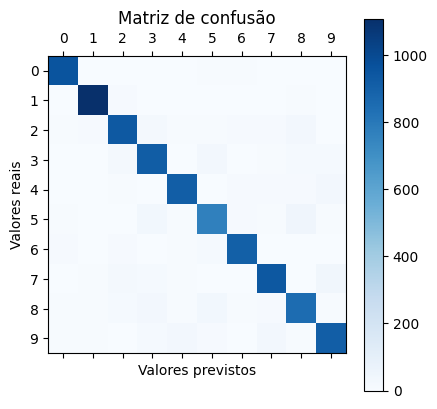

[[ 957    0    2    2    0    7    6    3    3    0]
 [   0 1109    9    3    0    1    3    2    7    1]
 [   5    9  932   21    8    5   11   11   28    2]
 [   3    1   22  917    0   28    2    6   17   14]
 [   1    0    8    2  911    0    9   11   10   30]
 [   8    4    4   34    7  766   12    6   46    5]
 [  12    2   11    2    8   14  905    1    3    0]
 [   1    5   23   16    5    0    0  940    3   35]
 [   8    7   13   27    8   34    6   11  852    8]
 [   8    7    1   13   28    9    0   26    6  911]]


In [11]:
# apresenta a matriz de confusão
from sklearn.metrics import confusion_matrix

y_pred = torch.argmax(model(X_test), dim=1).numpy()

# Calcula a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Mostra a matriz de confusão
plt.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel("Valores previstos")
plt.ylabel("Valores reais")
plt.title("Matriz de confusão")
plt.xticks(np.arange(0, 10))
plt.yticks(np.arange(0, 10))
plt.show()

print(cm)

Podemos ver que quase todas as previsões estão na diagonal principal, o que indica que nosso modelo é muito bom em prever as amostras do conjunto de teste. Entretanto, ainda há elementos fora dela, vamos plotar a mesma matriz sem a diagonal principal para ver melhor os erros do modelo.

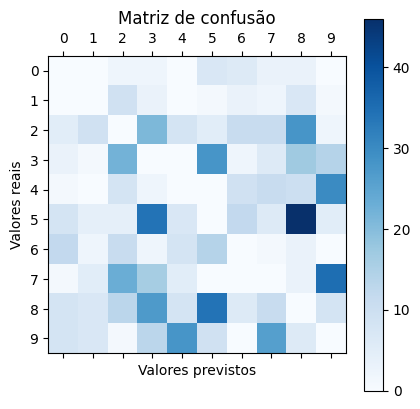

In [12]:
# zera a diagonal principal da cm
cm_mod = cm.copy()
np.fill_diagonal(cm_mod, 0)

# Mostra a matriz de confusão
plt.matshow(cm_mod, cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel("Valores previstos")
plt.ylabel("Valores reais")
plt.title("Matriz de confusão")
plt.xticks(np.arange(0, 10))
plt.yticks(np.arange(0, 10))
plt.show()

Aqui podemos ver que os valores que ela erra mais frequentemente é a previsão de 8 para 5, 9 para 7, 5 para 8, 5 para 3 e 3 para 5. Podemos ver uma certa simetria, indicando que o modelo confunde classes parecidas hora errando para um lado, hora errando para outro. As classes 0, 1 e6 tem poucas confusões enquanto a classe 3 se confunde com muitas classes, assim como 8. Isso possivelmente ocorre por possuírem muitos píxels, o que aumenta a chance de atingir padrões que a rede está detectando.

Vamos verificar algumas amostras que a rede está prevendo incorretamente.

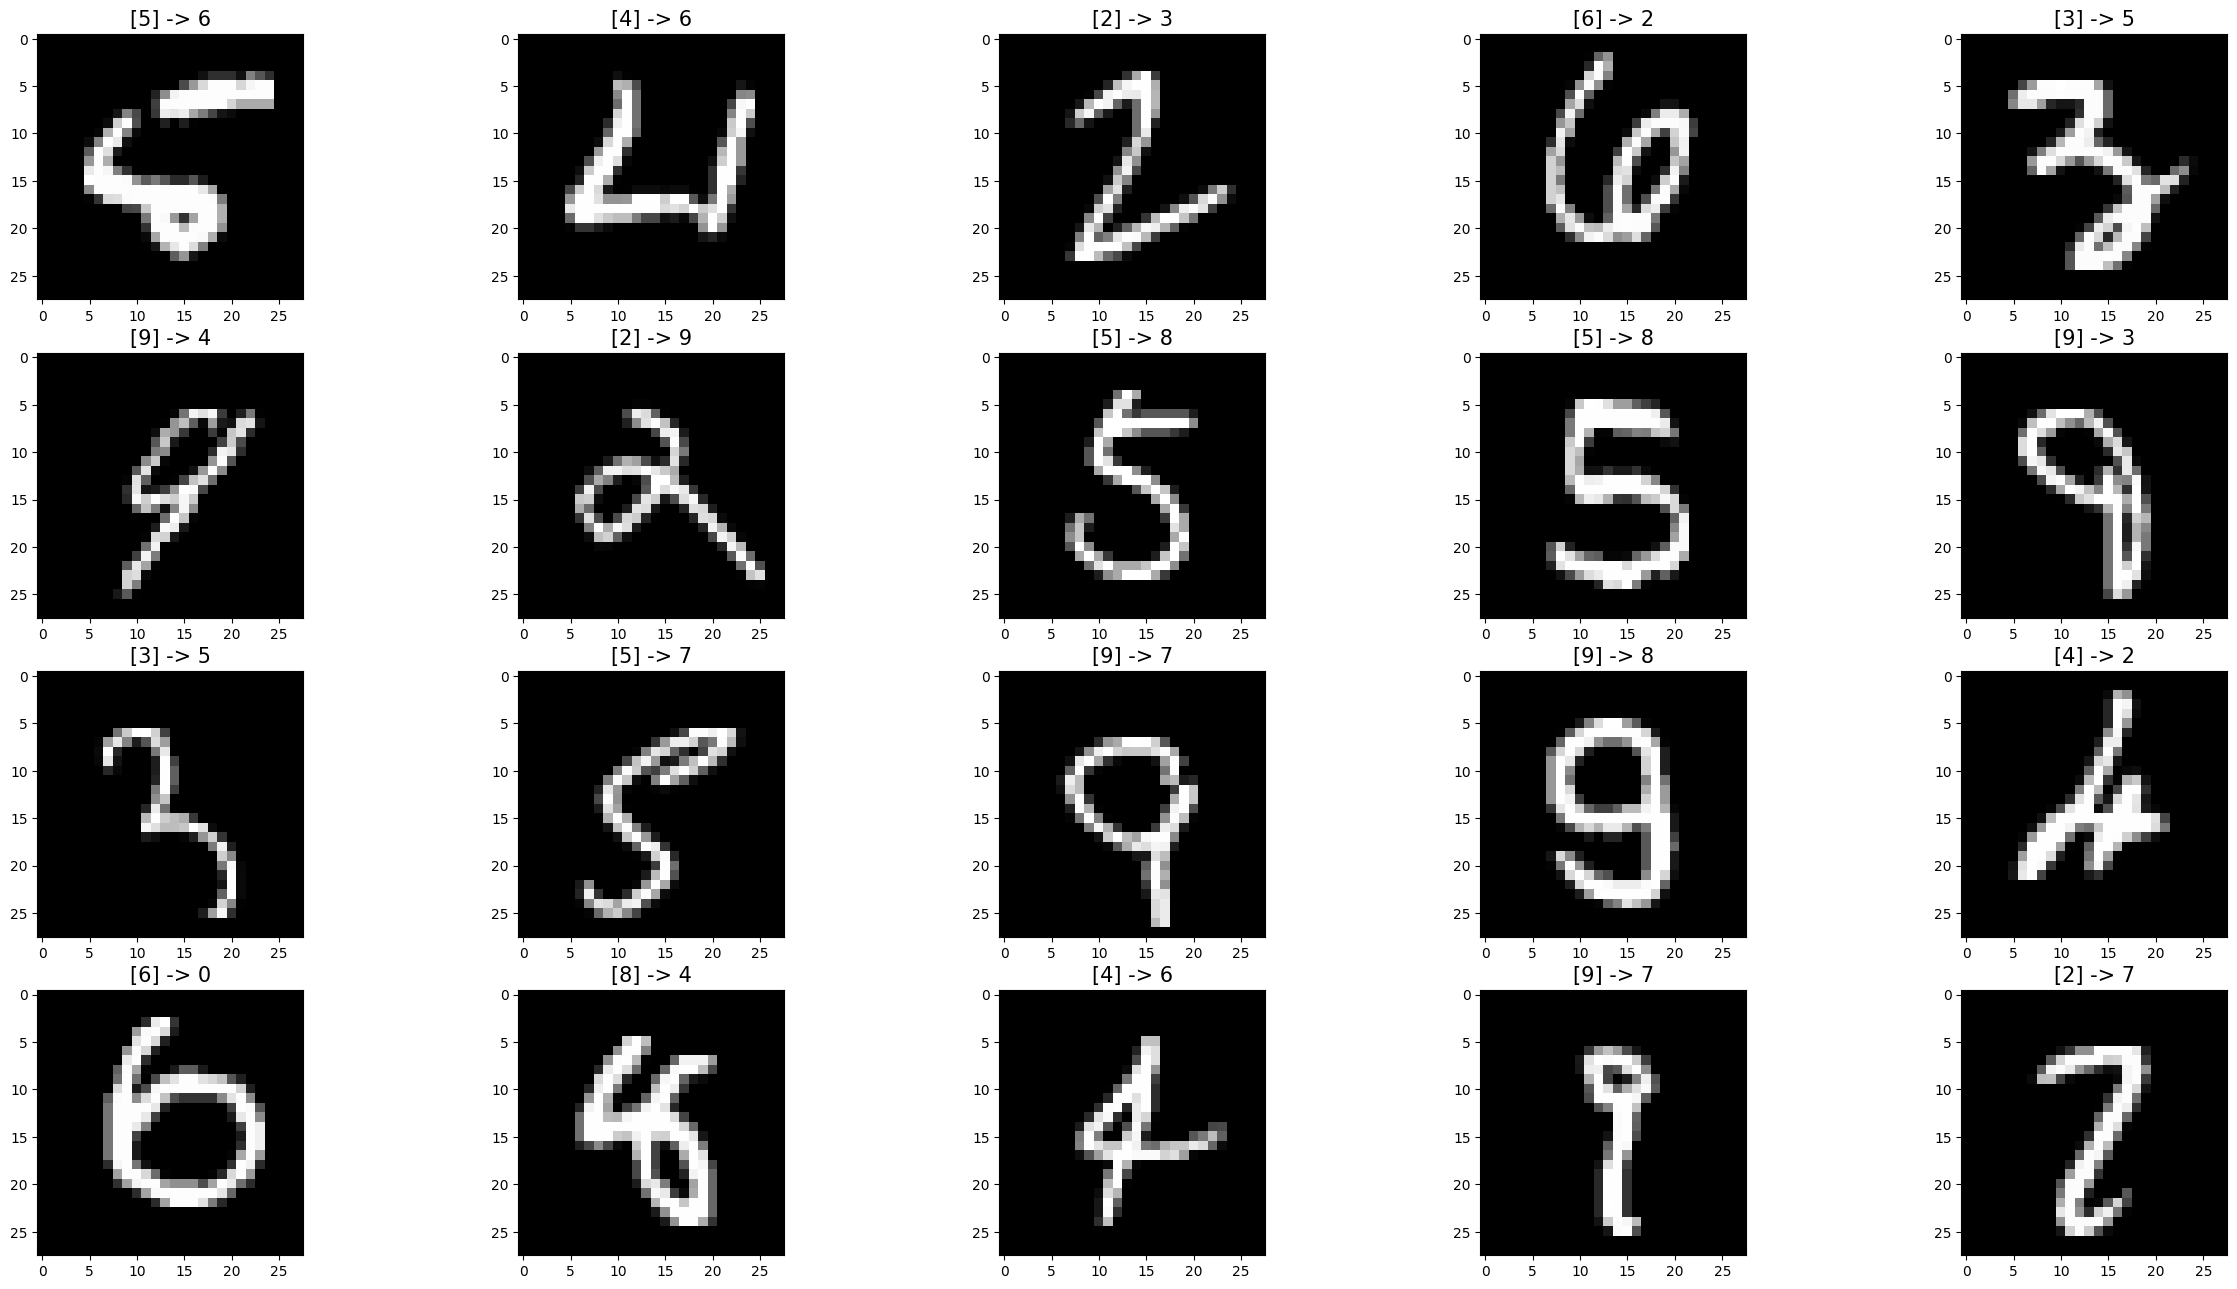

In [13]:
y_test_np = y_test.numpy()
X_test_np = X_test.numpy()


# Seleciona amostras que o modelo confundiu
idx_erros = np.where(y_test_np.reshape(y_test.shape[0]) != y_pred)[0]
X_erros = X_test_np[idx_erros]
y_erros = y_test_np[idx_erros]


imagens = X_erros[:20].reshape(-1, 28, 28)
# legenda deve ser no formato <correto> -> <previsto>
legendas = [f"{y_test_np[i]} -> {y_pred[i]}" for i in idx_erros[:20]]
# mostra apens 10 amostras
show_images(imagens, legendas)


Aqui podemos ver que os erros do modelo embarcam em sua maioria amostras difíceis de classificar, mas também há amostras fáceis que ele errou.

Aqui vou analisar algumas dessas amostras.
A primeira amostra não está muito clara, podendo facilmente ser confundida com um 6  devido a sua curva; A segunda não parece um quatro, uma vez que não possui a perna do número, mas ela não se parece com nenhum outro dígito, então o melhor chute aqui seria o próprio 4; O terceiro é compressível o erro com 2, uma vez que possui uma curva em si mesmo, mas esse é um caso fácil que o modelo não deveria ter errado. A quarta amostra é totalmente compreensível, e o modelo possivelmente está ignorando a primeira parte do 3; A quinta amostra realmente parece um 4, mas ela seria mais facilemte classificada como um 9, por possuir uma curva maior; A amostra [5]->8, [8] -> 7, [9]-> 8 e [6]-> 0 estão muito bem desenhadas  não há motivo para o modelo estar confundido-as. Por fim a amostra [8] -> 4 incrivelmente é visível a confusão do modelo, sendo u erro aceitável.

Assim podemos concluir que o modelo está aprendendo padrões para identificar corretamente os números, mas ainda falta o reconhecimento de alguns que se apresentam nessas amostras erradas, mesmo que algumas delas realmente sejam confusas.

# conclusão geral

Por fim, podemos concluir que temos as ferramentas matemáticas suficientes para criar e otimizar um modelo de regressão logística capaz de resolver satisfatoriamente a tarefa de reconhecimento de dígitos manuscritos do MNIST. Esses otimizadores são eficientes, mas possuem uma atuação ainda melhor com a estratégia de minibatches aleatórios. Além disso o ADAM gera um resultado mais rápido e melhor que o SGD, tendo diversas otimizações na biblioteca pytorch.